In [1]:
import yfinance as yf
import requests
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import datetime as dt
from math import floor
from termcolor import colored as cl
import matplotlib.pyplot as plt

In [2]:
name = ['SPGI','VZ','TSLA','PG','DIS','SYY','AAPL','XOM','BRK-B','UNH']
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()
df4 = pd.DataFrame()
df5 = pd.DataFrame()
df6 = pd.DataFrame()
df7 = pd.DataFrame()
df8 = pd.DataFrame()
df9 = pd.DataFrame()
df10 = pd.DataFrame()
d = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]

In [3]:
for i in range(10):
    d[i] = yf.download(name[i],start = '2019-01-01')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
#MACD Calculation
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'Close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df


In [5]:
for i in range(10):
    d[i][['macd','signal','hist']] = get_macd(d[i]['Close'], 26, 12, 9)
    

In [6]:
d[0].head()

,Open,High,Low,Close,Adj Close,Volume,macd,signal,hist
Date,,,,,,,,,
2019-01-02,169.270004,171.270004,167.000000,169.850006,164.012070,1362200,0.000000,0.000000,0.000000
2019-01-03,169.289993,169.399994,163.990005,164.369995,158.720413,1569500,-0.437152,-0.087430,-0.349721
2019-01-04,167.029999,172.919998,166.639999,172.259995,166.339249,1946800,-0.145266,-0.098998,-0.046269
2019-01-07,171.910004,175.320007,171.910004,173.639999,167.671783,1820500,0.195160,-0.040166,0.235326
2019-01-08,174.759995,175.250000,173.050003,175.229996,169.207138,1426700,0.586489,0.085165,0.501324


In [7]:
#Creating Trading Strategy
# only care about when to buy or sell, so other position is 0 if have been sold or bought.
def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal

In [9]:
buy_price = [0] * 10
sell_price = [0] * 10
macd_signal = [0] * 10
for i in range(10):
    buy_price[i], sell_price[i], macd_signal[i] = implement_macd_strategy(d[i]['Close'], d[i])

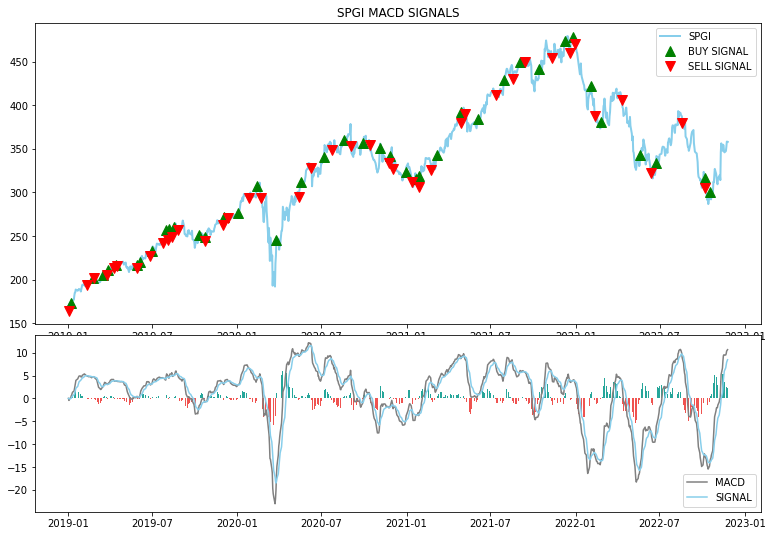

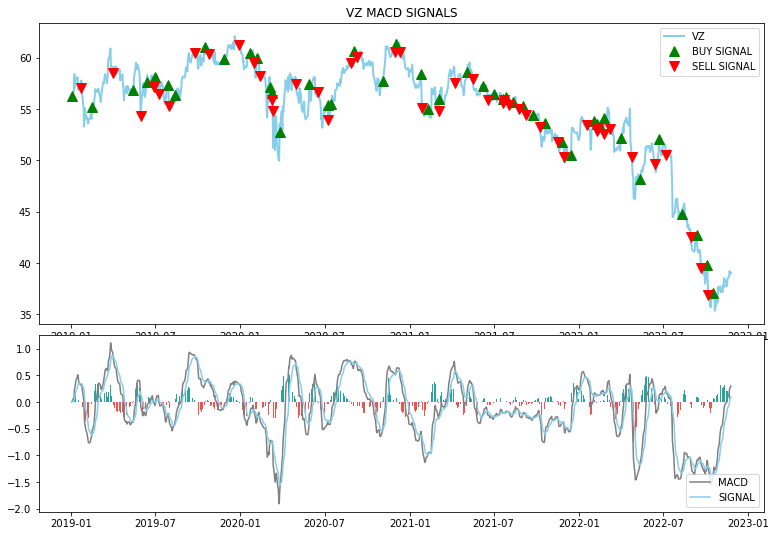

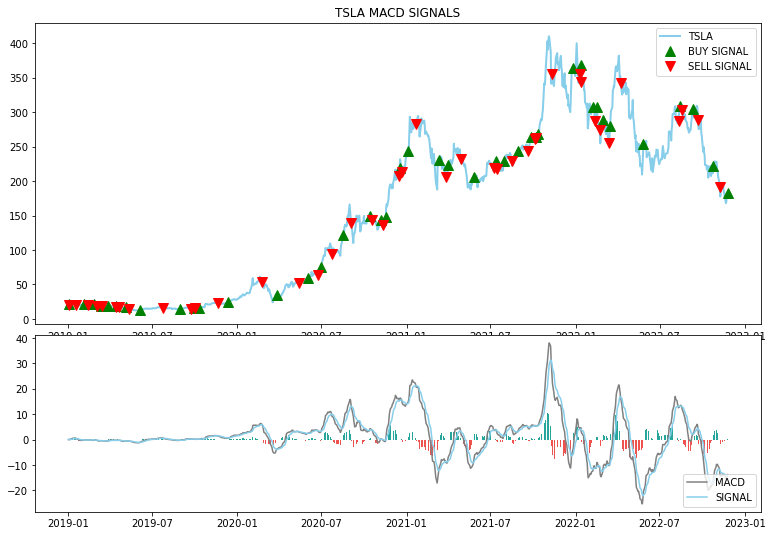

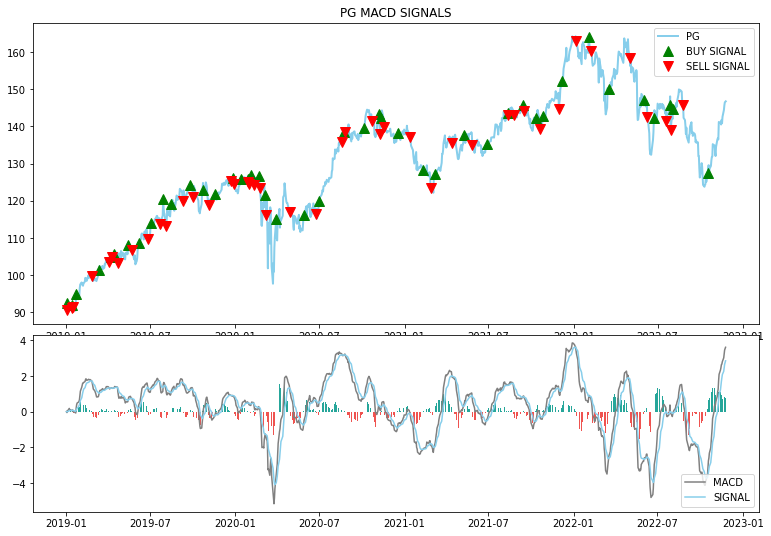

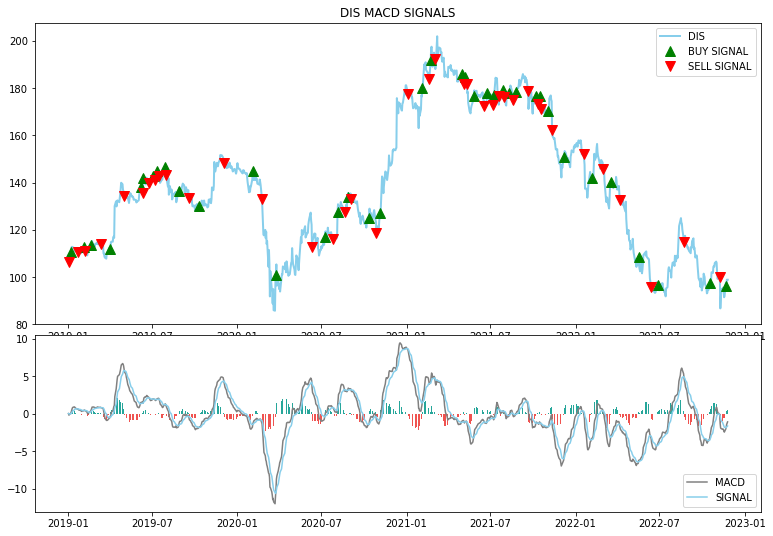

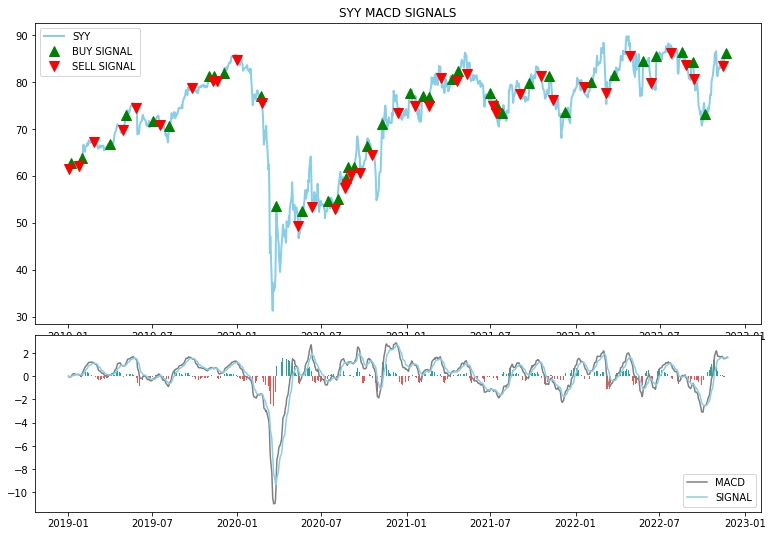

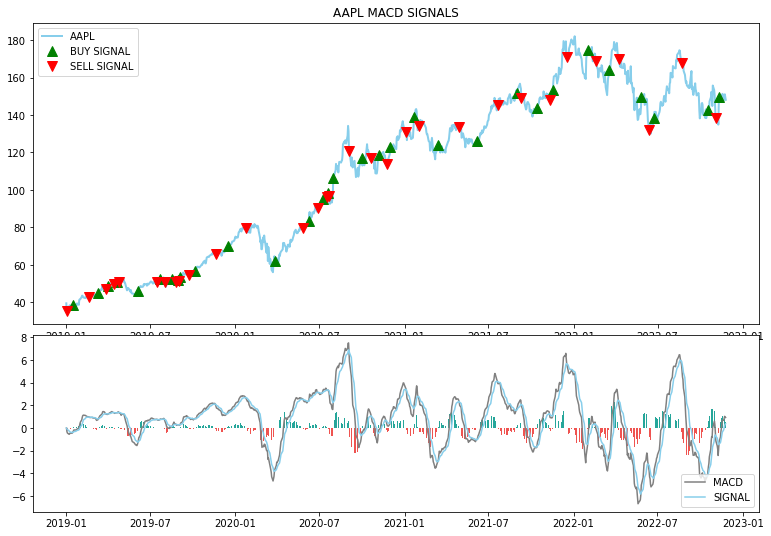

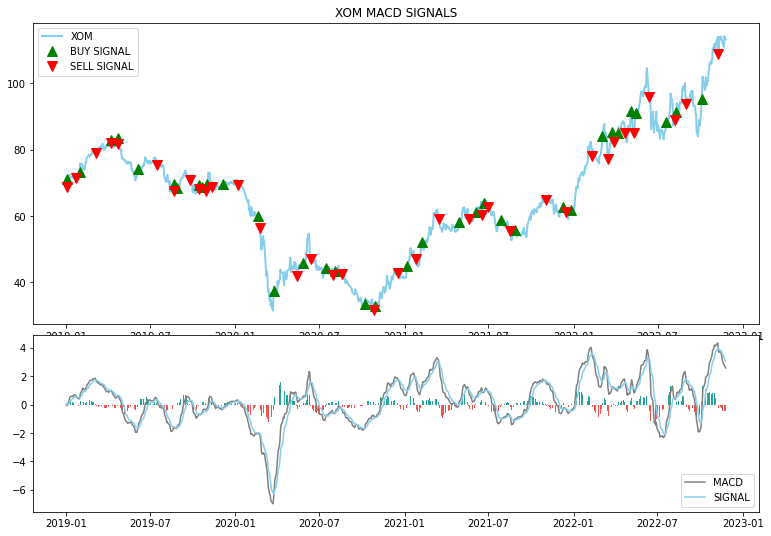

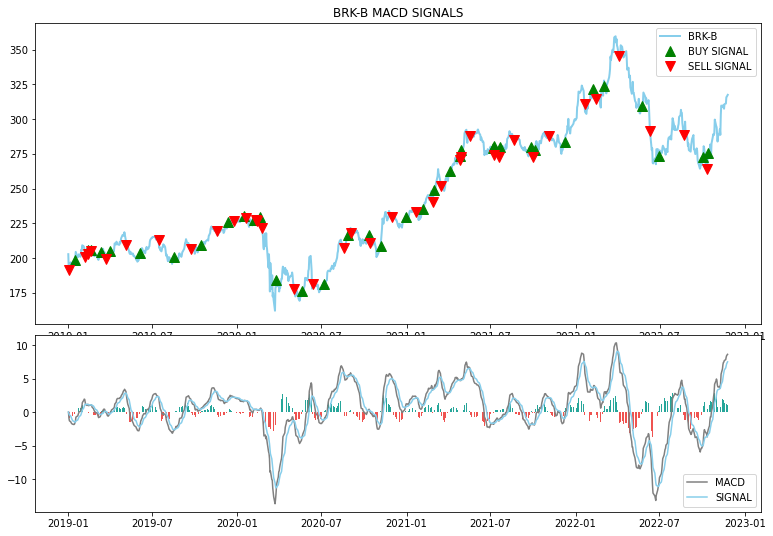

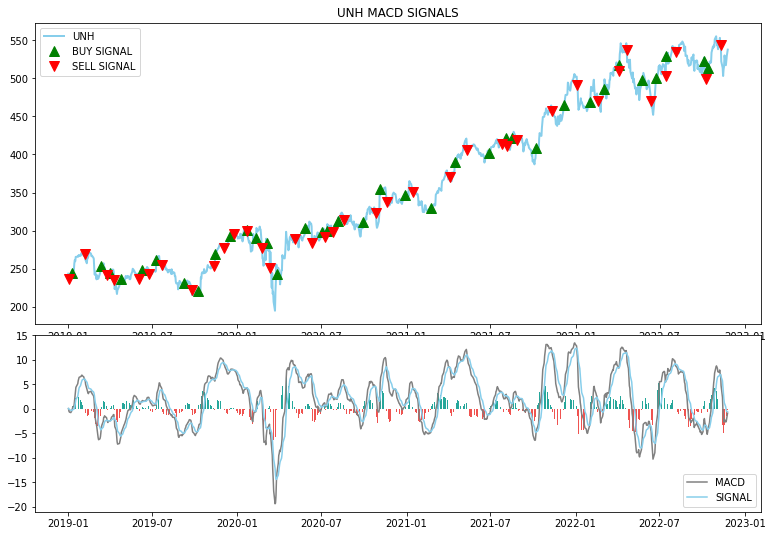

In [10]:
#Plotting Trading List
for j in range(10):
    fig, axs = plt.subplots(2, sharex=True, figsize=(13,9))
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(d[j]['Close'], color = 'skyblue', linewidth = 2, label =name[j])
    ax1.plot(d[j].index, buy_price[j], marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
    ax1.plot(d[j].index, sell_price[j], marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
    ax1.legend()
    ax1.set_title(name[j]+' MACD SIGNALS')
    ax2.plot(d[j]['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(d[j]['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(d[j])):
        if str(d[j]['hist'][i])[0] == '-':
            ax2.bar(d[j].index[i], d[j]['hist'][i], color = '#ef5350')
        else:
            ax2.bar(d[j].index[i], d[j]['hist'][i], color = '#26a69a')
        
    plt.legend(loc = 'lower right')
    plt.show()


In [11]:
strategy = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]

In [12]:
#Creating our Position
for j in range(10):
    position = []
    for i in range(len(macd_signal[j])):
        if macd_signal[j][i] > 1:
            position.append(0)
        else:
            position.append(1)
        
    for i in range(len(d[j]['Close'])):
        if macd_signal[j][i] == 1:
            position[i] = 1 # multiply 1 equals to buy
        elif macd_signal[j][i] == -1:
            position[i] = 0 
        else:
            position[i] = position[i-1]
        
    macd = d[j]['macd']
    signal = d[j]['signal']
    close_price = d[j]['Close']
    macd_signal[j] = pd.DataFrame(macd_signal[j]).rename(columns = {0:'macd_signal'}).set_index(d[j].index)
    position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(d[j].index)

    frames = [close_price, macd, signal, macd_signal[j], position]
    strategy[j] = pd.concat(frames, join = 'inner', axis = 1)


In [13]:
strategy[0].head()

,Close,macd,signal,macd_signal,macd_position
Date,,,,,
2019-01-02,169.850006,0.000000,0.000000,0,1
2019-01-03,164.369995,-0.437152,-0.087430,-1,0
2019-01-04,172.259995,-0.145266,-0.098998,0,0
2019-01-07,173.639999,0.195160,-0.040166,1,1
2019-01-08,175.229996,0.586489,0.085165,0,1


In [14]:
# do not need to minus-1 for cum
def calcReturns(df):
    df['returns'] = df['Close'] / df['Close'].shift(1)
    df['log_returns'] = np.log(df['returns'])
    df['strat_returns'] = df['macd_position'].shift(1) * df['returns']
    df['strat_log_returns'] = df['macd_position'].shift(1) * df['log_returns']
    df['cum_returns'] = np.exp(df['log_returns'].cumsum())  
    df['strat_cum_returns'] = np.exp(df['strat_log_returns'].cumsum())
  
    

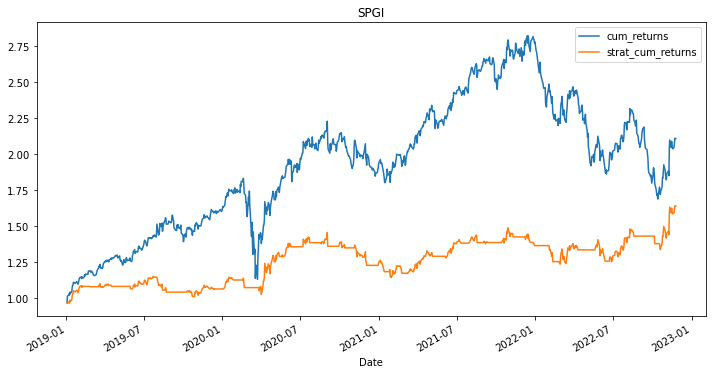

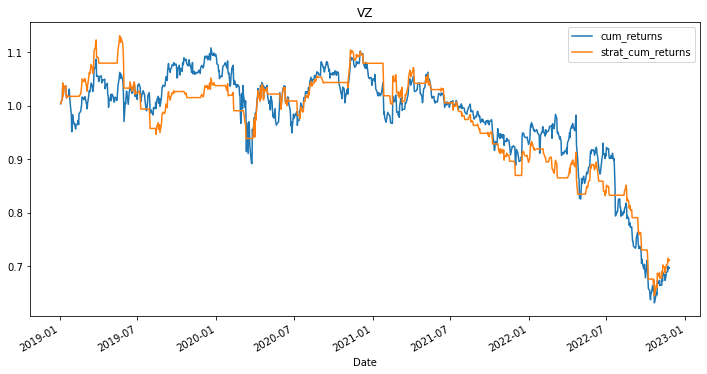

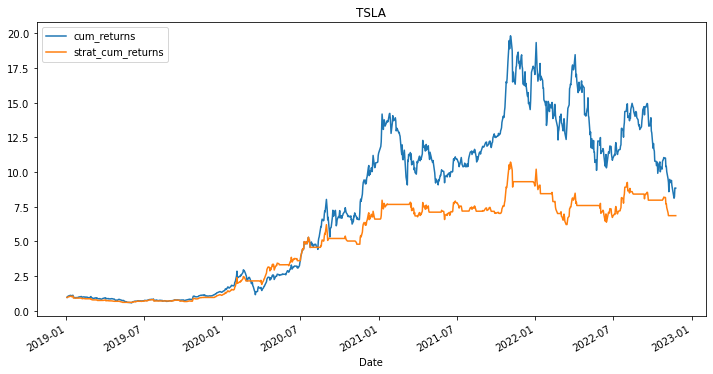

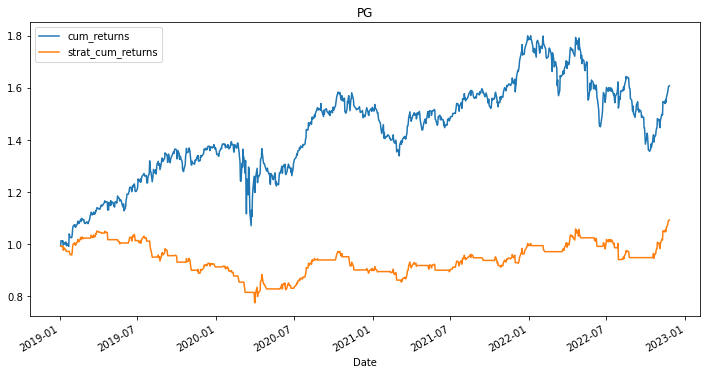

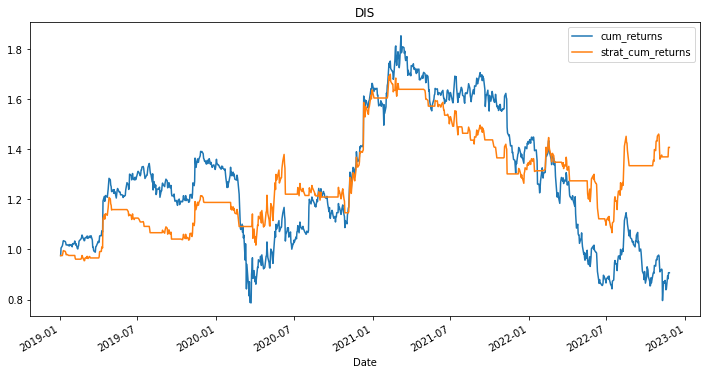

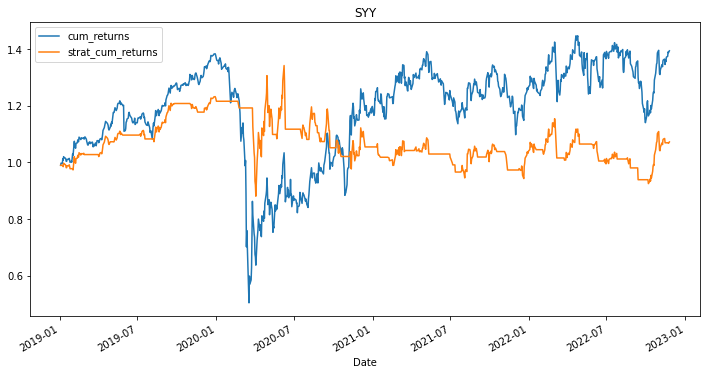

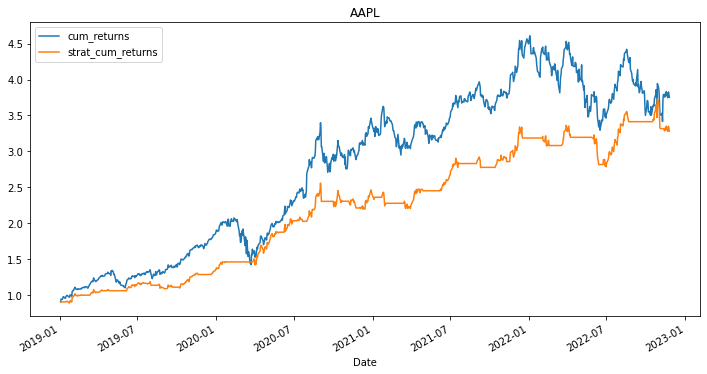

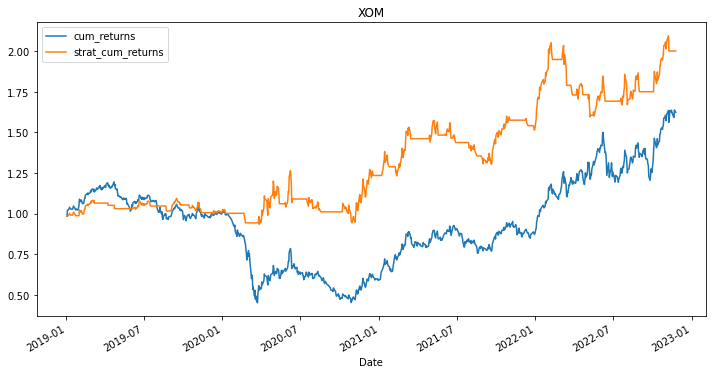

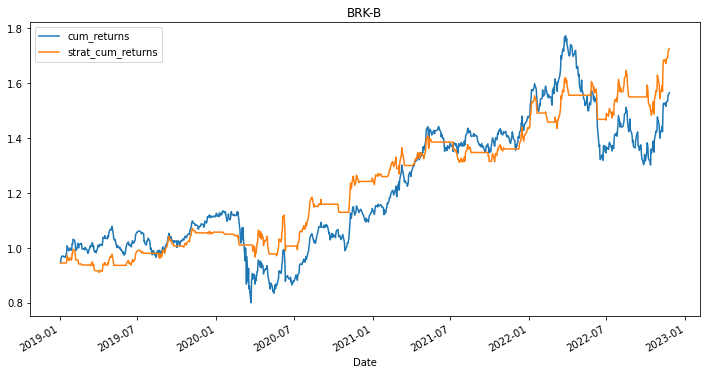

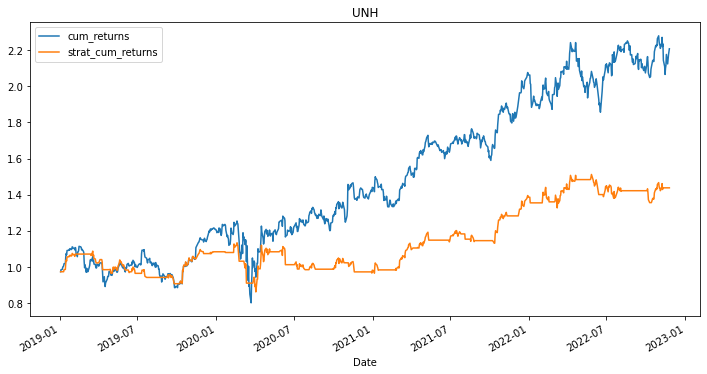

In [15]:
for i in range(10):
    calcReturns(strategy[i])
    (strategy[i][['cum_returns','strat_cum_returns']]).plot(figsize=(12,6))
    plt.title(label =name[i])
    plt.show()

## Sharpe Ratio

In [ ]:
# equal weights
# assign by capitalization

In [16]:
for i in range(10):
    strategy[i] = strategy[i][1:]

In [17]:
# assign weights for stocks in portfolio
weights = [0.1, 0.1, 0.1, 0.1, 0.1 ,0.1, 0.1, 0.1, 0.1, 0.1]
for stock_df, allocation in zip(strategy,weights):
     stock_df['Allocation'] = stock_df['strat_cum_returns'] * allocation

In [18]:
# add a column with the position value. Let’s assume our portfolio size is 10k on the first day. 
# We simply multiply it with the Allocation column which is already adjusted to the normalized return.
for stock_df in strategy:  
    stock_df['Position'] = stock_df['Allocation']*10000

In [19]:
# get all positions in one single table
all_pos = [strategy[0]['Position'], strategy[1]['Position'], strategy[2]['Position'], strategy[3]['Position'], strategy[4]['Position'], strategy[5]['Position'],
          strategy[6]['Position'], strategy[7]['Position'], strategy[8]['Position'], strategy[9]['Position']]
portf_val = pd.concat(all_pos, axis=1)
portf_val.columns = ['SPGI','VZ','TSLA','PG','DIS','SYY','AAPL','XOM','BRK-B','UNH']

In [20]:
# create a column to show the sum of all positions, which is our Total Position.
portf_val['Total Pos'] = portf_val.sum(axis=1)
portf_val.head()

,SPGI,VZ,TSLA,PG,DIS,SYY,AAPL,XOM,BRK-B,UNH,Total Pos
Date,,,,,,,,,,,
2019-01-03,967.736174,1003.570167,968.528287,992.988613,975.773154,989.041091,900.39263,984.646296,945.069037,972.729889,9700.475339
2019-01-04,967.736174,1006.069264,968.528287,992.988613,975.773154,989.041091,900.39263,984.646296,945.069037,972.729889,9702.974436
2019-01-07,967.736174,1012.495551,1021.178685,989.016282,975.773154,989.041091,900.39263,989.766665,945.069037,972.729889,9763.199159
2019-01-08,976.597594,1042.127822,1022.367619,992.666541,983.363291,989.041091,900.39263,996.963015,945.069037,972.729889,9821.318530
2019-01-09,967.847663,1018.386269,1032.062348,976.454897,994.395459,984.314879,900.39263,1002.221805,945.069037,972.729889,9793.874876


<AxesSubplot:xlabel='Date'>

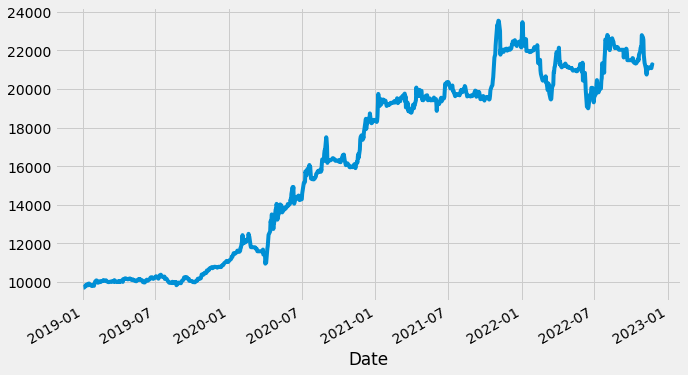

In [21]:
plt.style.use('fivethirtyeight')
portf_val['Total Pos'].plot(figsize=(10,6))

<AxesSubplot:xlabel='Date'>

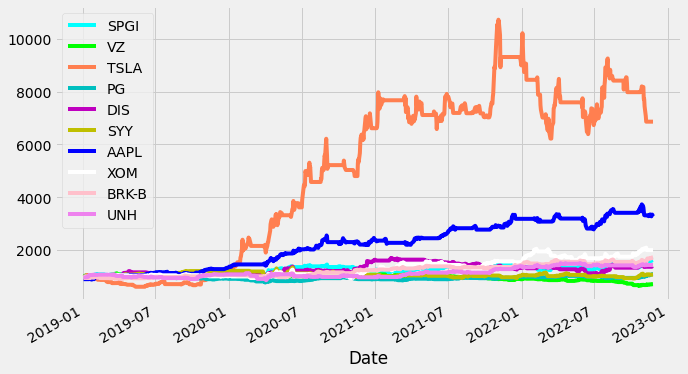

In [22]:
portf_val.drop('Total Pos', axis=1).plot(figsize=(10,6), color=['cyan', 'lime', 'coral', 'c', 'm', 'y', 'b', 'w','pink','violet'])

In [23]:
# Let’s see how much was our cumulative return.
cumulative_return = 100 * ( portf_val [ 'Total Pos' ] [-1] / portf_val ['Total Pos'] [2] -1)
print('Your cumulative return was {:.2f}%'.format(cumulative_return))
# We can check the portf_val last row to see how much our portfolio was worth.
portf_val.tail(1)

Your cumulative return was 117.47%


,SPGI,VZ,TSLA,PG,DIS,SYY,AAPL,XOM,BRK-B,UNH,Total Pos
Date,,,,,,,,,,,
2022-11-25,1639.469756,711.105023,6863.671124,1092.160499,1407.521133,1071.500426,3280.877895,2001.36774,1726.647616,1437.55249,21231.873702


In [24]:
# add the percentage change in each day Pandas dataframe.pct_change()函数计算当前和之前元素之间的百分比变化
portf_val['Daily Return'] = portf_val['Total Pos'].pct_change(1)

In [25]:
# Formula: (expected portfolio return - risk-free investment rate)/ portfolio’s standard deviation. 
Sharpe_Ratio = portf_val['Daily Return'].mean() / portf_val['Daily Return'].std()
Sharpe_Ratio

0.07997360504715646

In [26]:
# annualize the Sharpe ratio,252 trading days in the year
# multiply the Sharpe ratio by the square root of 252
A_Sharpe_Ratio = (252 ** 0.5)*Sharpe_Ratio
A_Sharpe_Ratio

1.2695416224244558

## P/L

In [27]:
strategy[0].head()

,Close,macd,signal,macd_signal,macd_position,returns,log_returns,strat_returns,strat_log_returns,cum_returns,strat_cum_returns,Allocation,Position
Date,,,,,,,,,,,,,
2019-01-03,164.369995,-0.437152,-0.087430,-1,0,0.967736,-0.032796,0.967736,-0.032796,0.967736,0.967736,0.096774,967.736174
2019-01-04,172.259995,-0.145266,-0.098998,0,0,1.048001,0.046885,0.000000,0.000000,1.014189,0.967736,0.096774,967.736174
2019-01-07,173.639999,0.195160,-0.040166,1,1,1.008011,0.007979,0.000000,0.000000,1.022314,0.967736,0.096774,967.736174
2019-01-08,175.229996,0.586489,0.085165,0,1,1.009157,0.009115,1.009157,0.009115,1.031675,0.976598,0.097660,976.597594
2019-01-09,173.660004,0.761161,0.220364,0,1,0.991040,-0.009000,0.991040,-0.009000,1.022432,0.967848,0.096785,967.847663


In [28]:
macd_strategy_ret_df = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]
macd_investment_ret_df = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]
total_investment_ret = [0]*10

In [29]:
# total investment_value $1 million
# calculate return 
for j in range(10):
    df_ret = pd.DataFrame(np.diff(strategy[j]['Close'])).rename(columns = {0:'returns'})
    macd_strategy_ret = []
    
    for i in range(len(df_ret)):
        returns = df_ret['returns'][i]*(strategy[j]['macd_position'][i])
        macd_strategy_ret.append(returns)
    
    macd_strategy_ret_df[j] = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

    # calculate investement return 
    investment_value = 100000
    number_of_stocks = floor(investment_value/(strategy[j]['Close'][0]))
    macd_investment_ret = []
    
    for i in range(len(macd_strategy_ret_df[j]['macd_returns'])):
        returns = number_of_stocks*macd_strategy_ret_df[j]['macd_returns'][i]
        macd_investment_ret.append(returns)
    
    macd_investment_ret_df[j] = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
    total_investment_ret[j] = round(sum(macd_investment_ret_df[j]['investment_returns']), 2)

In [30]:
total_investment_ret

[91972.11,
 -29390.32,
 795074.16,
 16986.28,
 36970.21,
 12869.13,
 335928.41,
 61718.58,
 79014.85,
 67490.44]

In [31]:
for i in range(10):
    investment_value = 100000
    profit_percentage = floor((total_investment_ret[i]/investment_value)*100)
    print(cl('Profit gained from the MACD strategy by investing $100k in {} : {}'.format(name[i],total_investment_ret[i]), attrs = ['bold']))
    print(cl('Profit percentage of the MACD strategy: {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the MACD strategy by investing $100k in SPGI : 91972.11
Profit percentage of the MACD strategy: 91%
Profit gained from the MACD strategy by investing $100k in VZ : -29390.32
Profit percentage of the MACD strategy: -30%
Profit gained from the MACD strategy by investing $100k in TSLA : 795074.16
Profit percentage of the MACD strategy: 795%
Profit gained from the MACD strategy by investing $100k in PG : 16986.28
Profit percentage of the MACD strategy: 16%
Profit gained from the MACD strategy by investing $100k in DIS : 36970.21
Profit percentage of the MACD strategy: 36%
Profit gained from the MACD strategy by investing $100k in SYY : 12869.13
Profit percentage of the MACD strategy: 12%
Profit gained from the MACD strategy by investing $100k in AAPL : 335928.41
Profit percentage of the MACD strategy: 335%
Profit gained from the MACD strategy by investing $100k in XOM : 61718.58
Profit percentage of the MACD strategy: 61%
Profit gained from the MACD strategy by investing

In [32]:
all_investment_value = 1000000
all_investment_ret = round(sum(total_investment_ret), 2)
all_profit_percentage = floor((all_investment_ret/all_investment_value)*100)
print(cl('Profit gained from the MACD strategy by investing 1 million in portfolio : {}'.format(all_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the MACD strategy: {}%'.format(all_profit_percentage), attrs = ['bold']))

Profit gained from the MACD strategy by investing 1 million in portfolio : 1468633.85
Profit percentage of the MACD strategy: 146%
